# A Script to show all the stages of the Slide renaming

----
### Import dependancies

In [1]:
import pytesseract as pytess
import numpy as np 
import skimage 
import scipy 
# import aicsimageio
import os 
import tifffile as tf
from PIL import Image
import tkinter as tk 
import pandas as pd
import matplotlib.pyplot as plt
from tkinter import filedialog

In [2]:
def corners_of_text(ordered):
    ''' '''
    # Initalise
    left_col = ordered[ordered['centroid-1'] < ordered['centroid-1'].min() + 25] 
    top_row = ordered[ordered['centroid-0'] < ordered['centroid-0'].min() + 25]
    bottom_row = ordered[ordered['centroid-1'] > ordered['centroid-1'].max() - 25]
    # Top left
    tl = left_col[left_col['centroid-0'] == left_col['centroid-0'].min()]
    # Bottom left
    bl = left_col[left_col['centroid-0'] == left_col['centroid-0'].max()]
    # Top Right
    tr = top_row[top_row['centroid-1'] == top_row['centroid-1'].max()]
    # Bottom Right
    br = bottom_row[bottom_row['centroid-0'] == bottom_row['centroid-0'].max()]
    # Put all the for points in the array. 
    four_corners = [np.array([tl['centroid-0'].iloc[0], tl['centroid-1'].iloc[0]]),
                    np.array([tr['centroid-0'].iloc[0], tr['centroid-1'].iloc[0]]), 
                    np.array([bl['centroid-0'].iloc[0], bl['centroid-1'].iloc[0]]), 
                    np.array([br['centroid-0'].iloc[0], br['centroid-1'].iloc[0]]) ]
    
    return(np.array(four_corners))

In [3]:
def get_letters_and_locs(label_im): 
    ''' '''
    # Initalise 
    props = {'label', 'area', 'centroid'}
    # 
    label = skimage.measure.label(image_data)
    # Find the properties of the letters. 
    label_props = pd.DataFrame( skimage.measure.regionprops_table(label, properties = props) )
    # Ignore the labels with an area smaller than 250 pixels.
    label_props = label_props[ label_props['area'] > 250 ]

    return(label, label_props)

In [4]:
def angle_calc(four_corners): 
    ''' ''' 
    print()
        
    # delta x 
    delta_x = four_corners[2][0] - four_corners[0][0]
    delta_y = four_corners[2][1] - four_corners[0][1]

    # angle 
    angle = 180 * ( np.arctan(delta_x / delta_y) / np.pi)

    return(angle)

---
### Import Tesseract engine

In [22]:
pytess.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'
pytess.pytesseract.tesseract_cmd = r'C:/Users/rcorbyn/AppData/Local/Programs/Tesseract-OCR/tesseract.exe'

----
### Get image 

In [6]:
# # # Get the folder containing the image stack. 
root = tk.Tk()
root.attributes('-topmost', True)
root.withdraw() # Stops a second window opening
file_loc = filedialog.askopenfilename(title = 'Select Stack file')

im_data = np.array( Image.open(file_loc) )
print(im_data.shape)

(695, 739, 3)


-----
### Get original label images

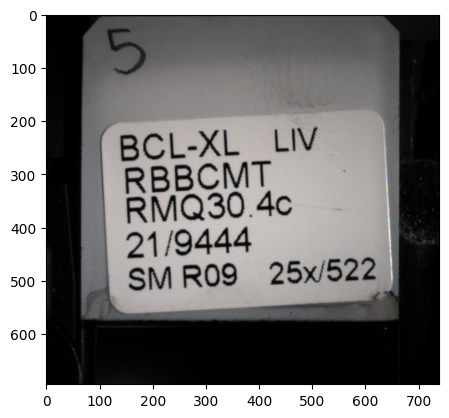

In [7]:
# Get the work directory
work_dir = os.path.dirname( 
           os.path.dirname(file_loc) ) + '/work/'
# Get filename
file_name = os.path.basename(file_loc)
# Find underscores in the filename
last_under = file_name.rfind('_')
# Loop around all files in a folder. 
for root, folders, files in os.walk(work_dir): 
    # Loop around all files
    for file in files: 
        # 
        if file[0:-4].find(file_name[0:last_under]) > -1 and len(file[0:-4]) == len(file_name[0:last_under]):
            original_image = Image.open(root + '/' + file) 
            original_image = np.array( original_image.convert('RGB') )

plt.imshow(original_image)

-------
### Edge Detection

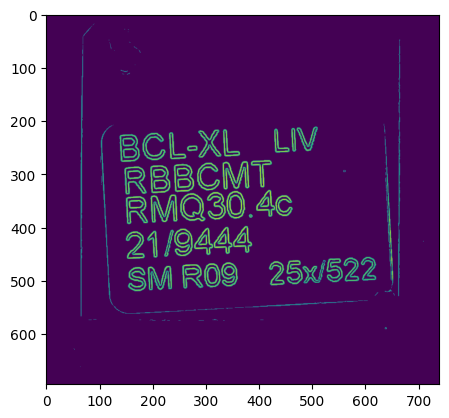

In [8]:
edges = skimage.filters.sobel( np.sum(original_image, axis = 2) )
#
# Find the threshold values
threshold_val = skimage.filters.threshold_otsu(edges)
edges[edges < threshold_val] = 0
plt.imshow(edges)

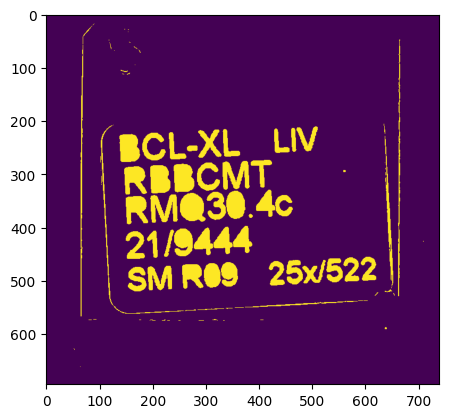

In [9]:
# Fill the binary masks of the letters
fill_string = scipy.ndimage.binary_fill_holes(edges)
plt.imshow(fill_string)

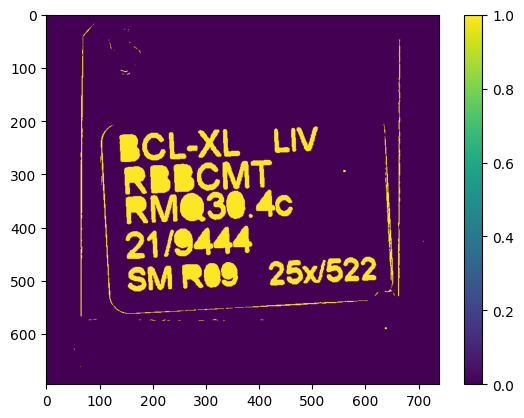

In [10]:
# Invert the image and multiply by the letter
# mask to get only the letters in the image. 
invert = skimage.util.invert( original_image[:, :, 0] ) * fill_string 
#####
# Create a binary image from the inverted letters
binary = np.array(invert)
binary[binary>0] = 1

plt.imshow(binary)
plt.colorbar()

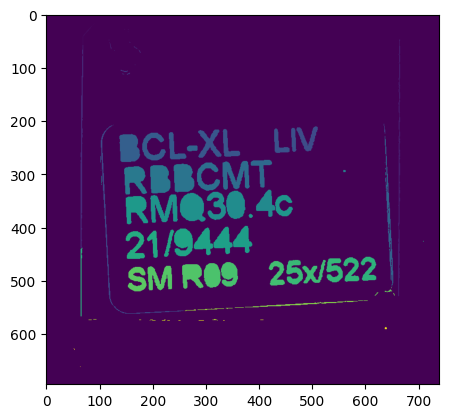

In [11]:
# create labels from the binary image. 
labels = skimage.measure.label(binary)
plt.imshow(labels)

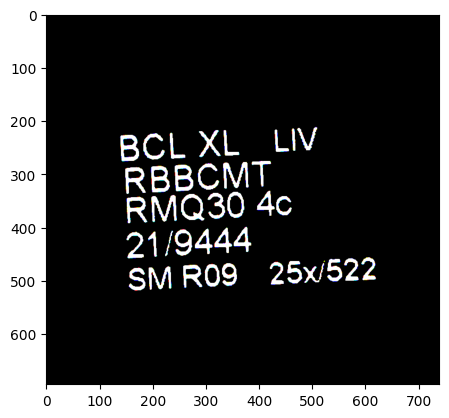

In [12]:
# Get properties of the letters and remaining masks. 
region_props = pd.DataFrame( skimage.measure.regionprops_table(
                labels, properties = {'label', 'area', 
                'axis_minor_length', 'axis_major_length'}) )

# Create a mask of zeros
filtered_image = np.zeros(original_image.shape)

# Loop around all labels. 
for i in range(region_props.shape[0]): 
    # Find the positon of mask i in the label image. 
    mask_pos = np.where(labels == region_props['label'].iloc[i])
    # Find the maximum and minimum height and width of the masks. 
    delta_x = np.abs( np.min(mask_pos[0]) - np.max(mask_pos[0]) ) 
    delta_y = np.abs( np.min(mask_pos[1]) - np.max(mask_pos[1]) ) 
    # If the mask is too long or high, remove 
    # Also remove if the area is too small. 
    if delta_x  <= 75 and delta_y <= 75 and region_props['area'].iloc[i] > 250: 
        # keep the mask. 
        filtered_image[mask_pos[0], mask_pos[1], :] = skimage.util.invert(
                            original_image[mask_pos[0], mask_pos[1], :] )
    
filtered_image = np.array(filtered_image, dtype = 'uint8')

filtered_image[filtered_image>150] = 255
filtered_image[filtered_image<150] = 0

plt.imshow(filtered_image)

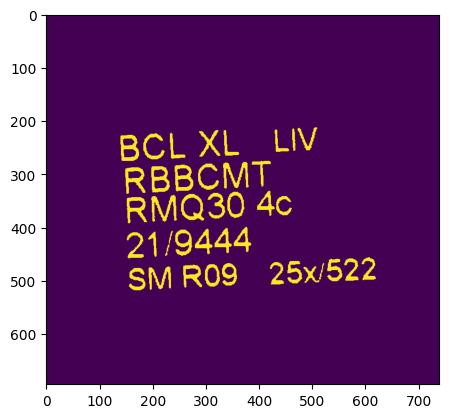

In [13]:
image_data = np.sum( filtered_image, axis = 2 )
# binery 
image_data[image_data < np.max(image_data)] = 0
image_data[image_data > 1] = 1

plt.imshow(image_data)

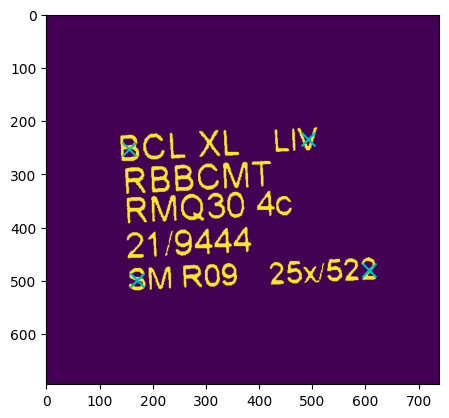

In [14]:
letters, properties = get_letters_and_locs(image_data)
corners = corners_of_text(properties)

plt.imshow(image_data)
for i in range( len(corners )):
    plt.scatter(corners[i, 1],  corners[i, 0], 
                marker = 'x', s=100, color = 'c')

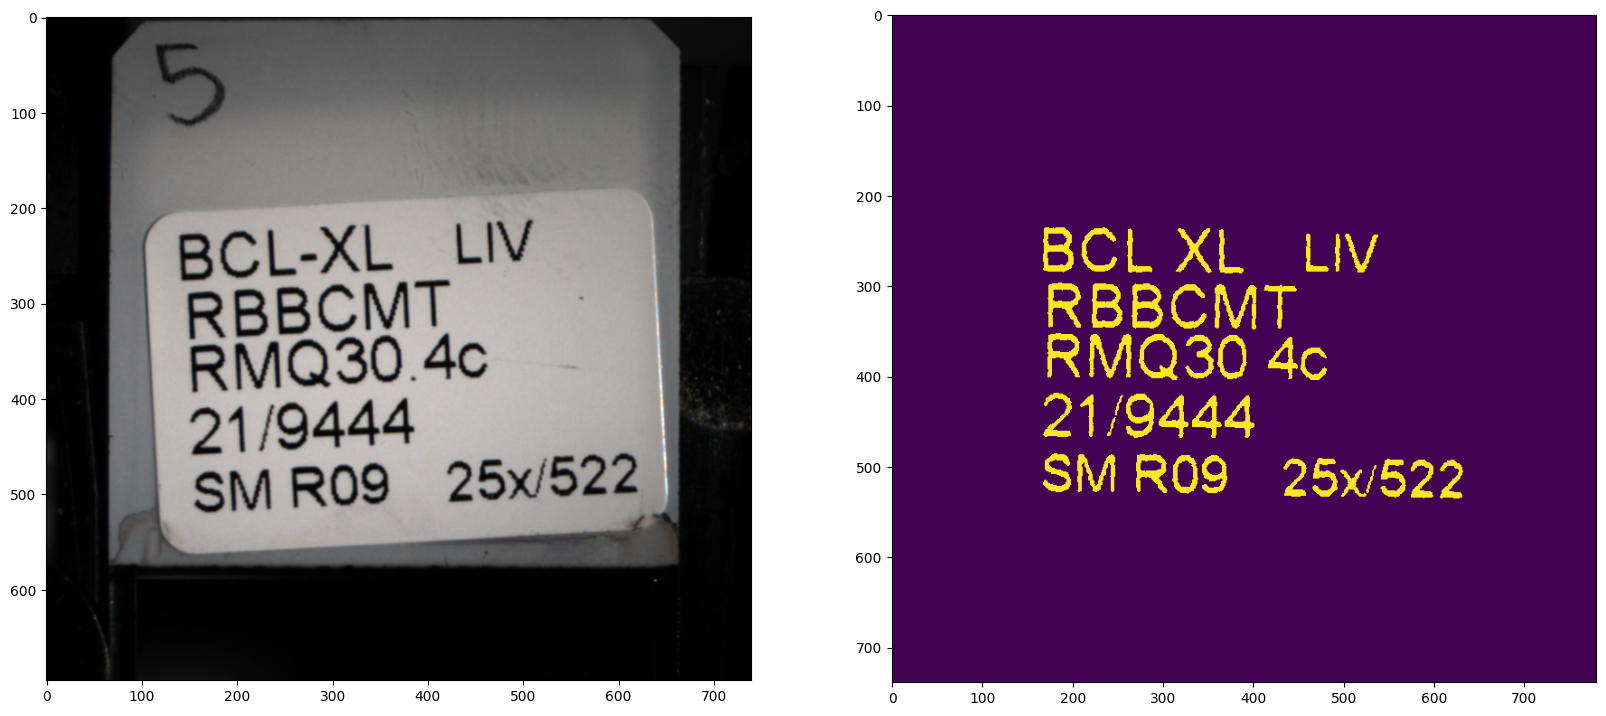

In [16]:
# Find the angle of rotation
angle = angle_calc(corners)

# Rotate the image by the angle found above.
if angle < -10:
    angle = 90 + angle
elif angle > 10:
    angle = angle - 90
# Rotate the image
rotated_letters = scipy.ndimage.rotate(image_data, angle ) 

fig, ax = plt.subplots(ncols = 2, figsize=(20, 10))
ax[0].imshow(original_image)
ax[1].imshow(rotated_letters)

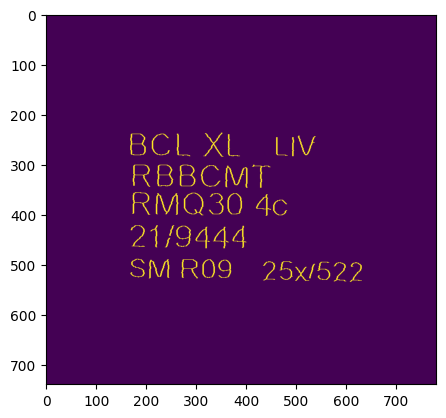

In [23]:
 # 
skelton = skimage.morphology.skeletonize(rotated_letters)
skelton = skelton + np.roll(skelton, (0,1)) + np.roll(skelton, (0,-1)
            ) + np.roll(skelton, (1,0))+ np.roll(skelton, (-1,0))

plt.imshow(skelton)
# 
label_text = pytess.image_to_string(skelton)

In [24]:
print(label_text)

BCL XL LIV
RBBCMT

RMQ30 4c
21/9444
SM ROG 25x/522


